# Visualize Layout Distribution (Attribute Histogram)

In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/app


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter, defaultdict
from hydra.utils import instantiate
from pathlib import Path
from tqdm import tqdm

import torch

from trainer.data.util import sparse_to_dense
from trainer.datasets.base import BaseDataset
from trainer.models.common.util import build_model
from trainer.helpers.util import set_seed, load_config

import scienceplots
plt.style.use(['science','no-latex', 'grid'])
plt.style.use(['science','no-latex'])

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Run inference to get the generated results

# !python ./bin/test_eval.py ./download/pretrained_weights/rico25/layoutdm/ rico25 -t 100 -d 0

# NOTE: When testing with the corrector, please set `corrector_t_list` in `bin/corrector_test_eval.py` to `[10,20,30], [10,20,...,50], and [10,20,...,90]` for reproduction.
# !python ./bin/corrector_test_eval.py ./download/pretrained_weights/rico25/layout_corrector/ rico25 -t 100 --corrector_mask_mode thresh --corrector_mask_threshold 0.7 -d 0

In [4]:
# config
# Set job_dir to get dataset information
GENERATOR_JOB_DIRS = {
    "rico": Path("./download/pretrained_weights/rico25/layoutdm/0/"),
    "publaynet": Path("./download/pretrained_weights/publaynet/layoutdm/0/"),
    "crello": Path("./download/pretrained_weights/crello-bbox/layoutdm/0/")
}

target_dataset = "rico"
assert target_dataset in GENERATOR_JOB_DIRS.keys()
GENERATOR_JOB_DIR = GENERATOR_JOB_DIRS[target_dataset]

generator_config_path = GENERATOR_JOB_DIR / "config.yaml"
generator_train_cfg = load_config(str(generator_config_path))

generator = build_model(generator_train_cfg, device=torch.device("cpu"))
tokenizer = generator.tokenizer

In [5]:
# Utility
def set_axis_labels(ax, title=None, xlabel=None, ylabel=None, fontsize=16):
    if title: ax.set_title(title, fontsize=fontsize, pad=2)
    if xlabel: ax.set_xlabel(xlabel, fontsize=fontsize-2, labelpad=2)
    if ylabel: ax.set_ylabel(ylabel, fontsize=fontsize-2, labelpad=2)
    ax.tick_params(labelsize=fontsize-4, colors='#111111')
    ax.xaxis.label.set_color('#111111') #setting up X-axis label color 
    ax.yaxis.label.set_color('#111111')

### From Dataset
This corresponds to the ground truth distribution

In [6]:
dataset = instantiate(generator_train_cfg.dataset)(split="test", transform=None)

In [7]:
def distribution_from_dataset(dataset: BaseDataset):
    dataset_category_list = []
    dataset_x_list, dataset_y_list = [], [] 
    dataset_w_list, dataset_h_list = [], []
    dataset_bbox_area_list = []
    for data in tqdm(dataset):
        bbox, label, _, mask = sparse_to_dense(data)
        bbox = bbox.squeeze(0)    # (1, seq, 4) -> (seq, 4)
        label = label.squeeze(0)  # (1, seq) -> (seq)
        dataset_category_list += label.tolist()
        bbox_xs = bbox[..., 0].tolist()
        dataset_x_list += bbox_xs
        bbox_ys = bbox[..., 1].tolist()
        dataset_y_list += bbox_ys
        bbox_ws = bbox[..., 2].tolist()
        dataset_w_list += bbox_ws
        bbox_hs = bbox[..., 3].tolist()
        dataset_h_list += bbox_hs
        bbox_area = [w * h for w, h in zip(bbox_ws, bbox_hs)]
        dataset_bbox_area_list += bbox_area
    return dataset_category_list, dataset_x_list, dataset_y_list, dataset_w_list, dataset_h_list, dataset_bbox_area_list

In [8]:
dataset_category_list, dataset_x_list, dataset_y_list, dataset_w_list, dataset_h_list, dataset_bbox_area_list = distribution_from_dataset(dataset)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4218/4218 [00:01<00:00, 3468.13it/s]


In [9]:
# Count category frequency
dataset_category_counter = Counter(dataset_category_list)
dataset_catid_count_pairs = sorted(dataset_category_counter.items(), key=lambda x: x[0])
total_elements = sum(dataset_category_counter.values())
dataset_catid2count = {d[0]: d[1] / total_elements for d in dataset_catid_count_pairs}

### From Pickles

In [10]:
def distribution_from_pickles(pickle_path_list: list[Path]):
    pkl_cat_list = []
    pkl_x_list, pkl_y_list = [], [] 
    pkl_w_list, pkl_h_list = [], []
    pkl_bbox_area_list = []

    for pkl_path in pickle_path_list:
        print(pkl_path)
        with open(pkl_path, "br") as f:
            data = pickle.load(f)

        results = data["results"]
        for layout in results:
            bbox = layout[0]
            bbox_xs = [xywh[0] for xywh in bbox]
            pkl_x_list += bbox_xs
            bbox_ys = [xywh[1] for xywh in bbox]
            pkl_y_list += bbox_ys
            bbox_ws = [xywh[2] for xywh in bbox]
            pkl_w_list += bbox_ws
            bbox_hs = [xywh[3] for xywh in bbox]
            pkl_h_list += bbox_hs
            bbox_area = [w * h for w, h in zip(bbox_ws, bbox_hs)]
            pkl_bbox_area_list += bbox_area
            
            label = layout[1].tolist()
            pkl_cat_list += label
    return pkl_cat_list, pkl_x_list, pkl_y_list, pkl_w_list, pkl_h_list, pkl_bbox_area_list


In [11]:
# NOTE: Set the path, where the results are saved by `bin/test_eval.py` and `bin/test_corrector_eval.py`
RESULT_TITLE_PAIRS = [
    (Path("./results/rico25/layoutdm/unconditional_temperature_1.0_name_random_num_timesteps_100_1000_samples_20240829025013/"), "LayoutDM"),
    (Path("./results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829004230/"), r"+ Corrector $t=[10,20,30]$"),
    (Path("./results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829021810/"), r"+ Corrector $t=[10,20,\cdots,50]$"),
    (Path("./results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829022230/"), r"+ Corrector $t=[10,20,\cdots,90]$"),
]

In [12]:
num_labels = len(dataset.labels)

label2stats = defaultdict(dict)
for result_root, title in RESULT_TITLE_PAIRS:
    PICKLES = list(result_root.glob("seed_*.pkl"))
    pkl_cat_list, pkl_x_list, pkl_y_list, pkl_w_list, pkl_h_list, pkl_bbox_area_list = distribution_from_pickles(PICKLES)

    pkl_cat_counter = Counter(pkl_cat_list)
    for k in range(num_labels):
        if k not in pkl_cat_counter:
            pkl_cat_counter[k] = 0
    pkl_catid_count_pairs = sorted(pkl_cat_counter.items(), key=lambda x: x[0])
    pkl_total_elements = sum(pkl_cat_counter.values())
    pkl_catid2count = {d[0]: d[1] / pkl_total_elements for d in pkl_catid_count_pairs}
    
    label2stats[title]["cat"] = pkl_catid2count
    label2stats[title]["x"] = pkl_x_list
    label2stats[title]["y"] = pkl_y_list
    label2stats[title]["w"] = pkl_w_list
    label2stats[title]["h"] = pkl_h_list
    label2stats[title]["area"] = pkl_bbox_area_list        

results/rico25/layoutdm/unconditional_temperature_1.0_name_random_num_timesteps_100_1000_samples_20240829025013/seed_0.pkl
results/rico25/layoutdm/unconditional_temperature_1.0_name_random_num_timesteps_100_1000_samples_20240829025013/seed_1.pkl
results/rico25/layoutdm/unconditional_temperature_1.0_name_random_num_timesteps_100_1000_samples_20240829025013/seed_2.pkl
results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829004230/seed_0.pkl
results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829004230/seed_1.pkl
results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829004230/seed_2.pkl
results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829021810/seed_0.pkl
results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829021810/seed_1.pkl
results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829021810/seed_2.pkl
results/rico25/layout_corrector/unconditional_thresh_0.

### Compare Pickles with Dataset (=GT) Distribution

#### Category Tokens

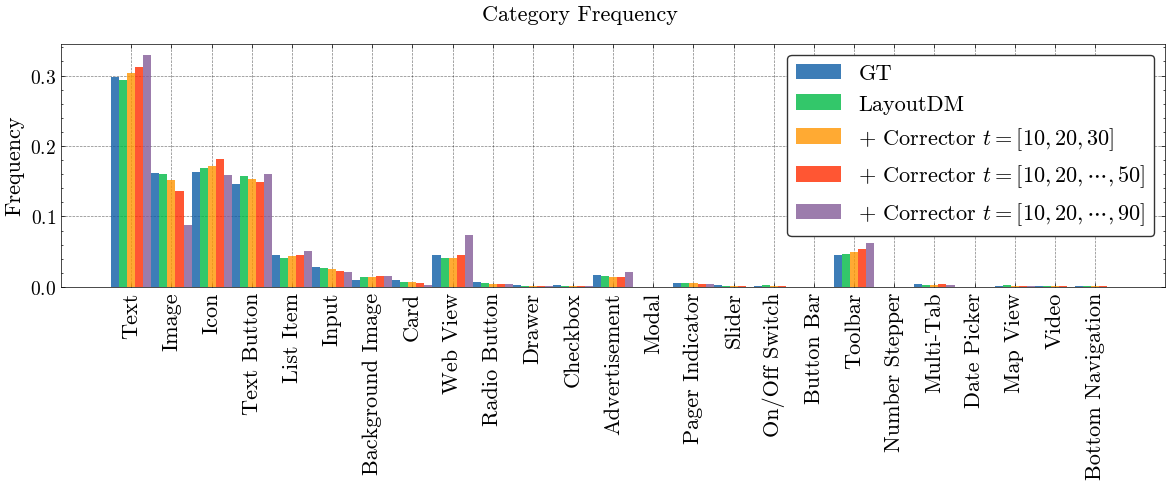

In [13]:
d_labels = dataset.labels
x = np.arange(len(d_labels))
n_data = 1 + len(label2stats)
width = int(10 * (1 / n_data)) / 10

fig, ax = plt.subplots(figsize=(12, 5), layout="tight")
ax.bar(x + (1 - n_data)/2 * width, dataset_catid2count.values(), width, label="GT", alpha=0.8)
multiplier = (1 - n_data)/2 + 1
for label, stats in label2stats.items():
    ax.bar(x + multiplier * width, stats["cat"].values(), width, label=label, alpha=0.8)
    multiplier += 1
ax.legend(loc="upper right", frameon=True, edgecolor=(0.2, 0.2, 0.2), facecolor=(1, 1, 1, 0.5), fontsize=16)
ax.set_xticks(x, d_labels, rotation=90, fontsize=16)
ax.tick_params(axis='x', which='minor', length=0)
ax.set_ylabel("Frequency", fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.grid(axis="y", alpha=0.5)
plt.suptitle("Category Frequency", fontsize=16)
plt.show()
plt.close()

### Bbox X-center

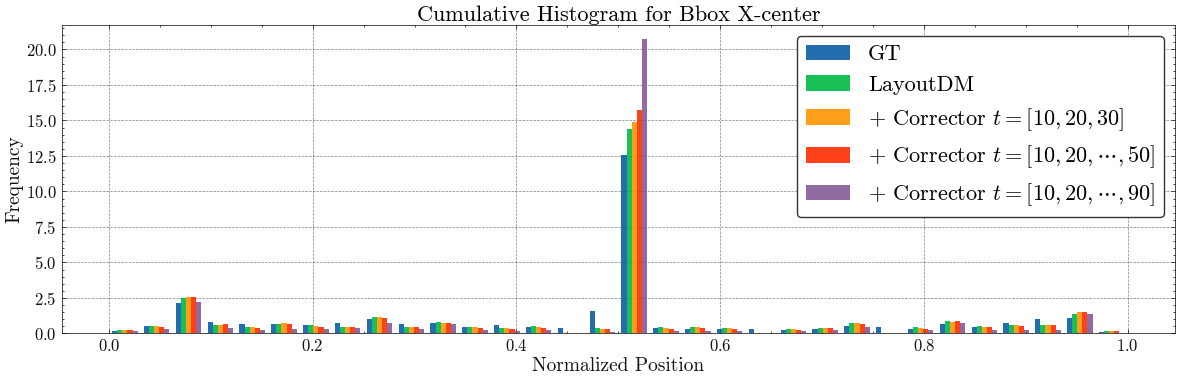

In [14]:
# dataset_x_list, pkl_x_list
n_bins = 32
fig, ax = plt.subplots(figsize=(12, 4), layout="tight")

stats_list = [dataset_x_list] + [v['x'] for v in label2stats.values()]
label_list = ['GT'] + list(label2stats.keys())
ax.hist(stats_list, range=[0, 1], bins=n_bins, density=True, cumulative=False, label=label_list, alpha=0.9)

ax.legend(frameon=True, edgecolor=(0.2, 0.2, 0.2), facecolor=(1, 1, 1, 0.5), fontsize=16)
set_axis_labels(ax, title="Cumulative Histogram for Bbox X-center", xlabel="Normalized Position", ylabel="Frequency", fontsize=16)
plt.show()

### Bbox Y-Center

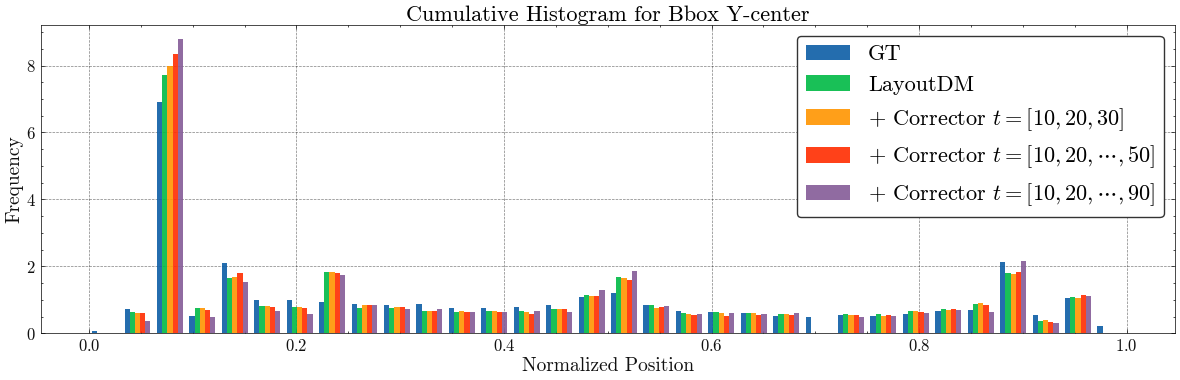

In [15]:
# dataset_y_list, pkl_y_list
n_bins = 32
fig, ax = plt.subplots(figsize=(12, 4), layout="tight")

stats_list = [dataset_y_list] + [v['y'] for v in label2stats.values()]
label_list = ['GT'] + list(label2stats.keys())
ax.hist(stats_list, range=[0, 1], bins=n_bins, density=True, cumulative=False, label=label_list, alpha=0.9)

ax.legend(frameon=True, edgecolor=(0.2, 0.2, 0.2), facecolor=(1, 1, 1, 0.5), fontsize=16)
set_axis_labels(ax, title="Cumulative Histogram for Bbox Y-center", xlabel="Normalized Position", ylabel="Frequency", fontsize=16)
plt.show()

### Bbox Width

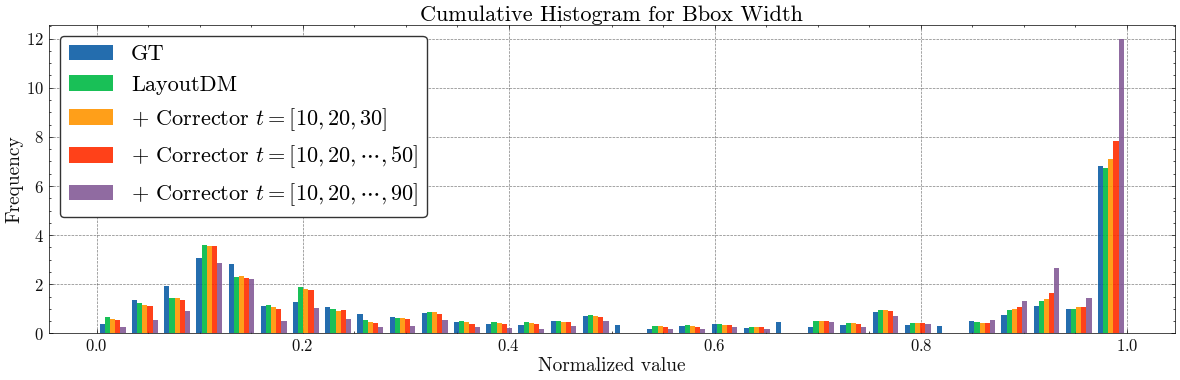

In [16]:
n_bins = 32
fig, ax = plt.subplots(figsize=(12, 4), layout="tight")

stats_list = [dataset_w_list] + [v['w'] for v in label2stats.values()]
label_list = ['GT'] + list(label2stats.keys())
ax.hist(stats_list, range=[0, 1], bins=n_bins, density=True, cumulative=False, label=label_list, alpha=0.9)

ax.legend(frameon=True, edgecolor=(0.2, 0.2, 0.2), facecolor=(1, 1, 1, 0.5), fontsize=16)
set_axis_labels(ax, title="Cumulative Histogram for Bbox Width", xlabel="Normalized value", ylabel="Frequency", fontsize=16)
plt.show()

### Bbox Height

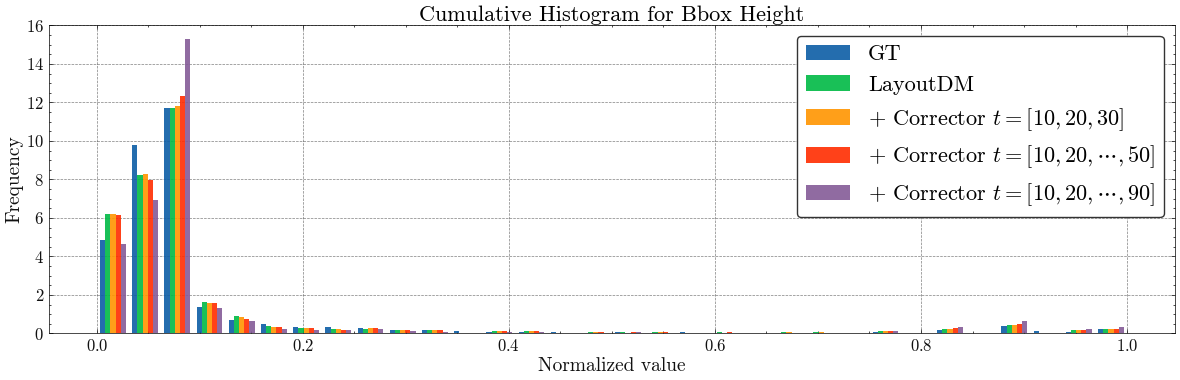

In [17]:
n_bins = 32
fig, ax = plt.subplots(figsize=(12, 4), layout="tight")

stats_list = [dataset_h_list] + [v['h'] for v in label2stats.values()]
label_list = ['GT'] + list(label2stats.keys())
ax.hist(stats_list, range=[0, 1], bins=n_bins, density=True, cumulative=False, label=label_list, alpha=0.9)

ax.legend(frameon=True, edgecolor=(0.2, 0.2, 0.2), facecolor=(1, 1, 1, 0.5), fontsize=16)
set_axis_labels(ax, title="Cumulative Histogram for Bbox Height", xlabel="Normalized value", ylabel="Frequency", fontsize=16)
plt.show()